In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from scipy.stats import skewnorm

from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats
import pandas as pdrestar
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [2]:
# If you saved as CSV:
df = pd.read_csv('processed_ABCDEats_data.csv')

# Or if you saved as pickle:
#df = pd.read_pickle('processed_ABCDEats_data.pkl')

df_original =  pd.read_csv('original_ABCDEats_data.csv')



/tmp/ipykernel_193/2260363746.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original =  pd.read_csv('original_ABCDEats_data.csv')


In [3]:
# check dataset data types again
df.dtypes

customer_id            object
customer_region        object
customer_age            int64
vendor_count            int64
product_count           int64
                        ...  
midday_orders           int64
evening_orders          int64
night_orders            int64
drinking_orders         int64
primary_time_period    object
Length: 72, dtype: object

In [4]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def preprocess_features(df_dropped):
    """
    Preprocess features including scaling numerical features and encoding categoricals
    """
    # Identify numeric and categorical columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object']).columns
    
    # Remove identifier columns that shouldn't be used for clustering
    columns_to_drop = ['customer_id']
    numeric_features = numeric_features.drop(columns_to_drop) if any(x in numeric_features for x in columns_to_drop) else numeric_features
    categorical_features = categorical_features.drop(columns_to_drop) if any(x in categorical_features for x in columns_to_drop) else categorical_features
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Scale numeric features
    df_scaled = df.copy()
    df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    # One-hot encode categorical variables
    # Using pd.get_dummies() for simplicity, could use sklearn's OneHotEncoder for more control
    df_encoded = pd.get_dummies(df_scaled, columns=categorical_features, drop_first=True)
    
    return df_encoded

def get_clustering_features(df_encoded):
    """
    Select and return relevant features for clustering
    """
    # List of features to exclude from clustering
    exclude_features = [
        'customer_id',  # Identifier
        'first_order',  # Already captured in other features
        'last_order',   # Already captured in other features
    ]

    
    
    # Get feature columns excluding the ones we don't want
    clustering_features = [col for col in df_encoded.columns if col not in exclude_features]
    
    return df_encoded[clustering_features]


# Example usage:
preprocessed_df = preprocess_features(df)
clustering_features_df = get_clustering_features(preprocessed_df)

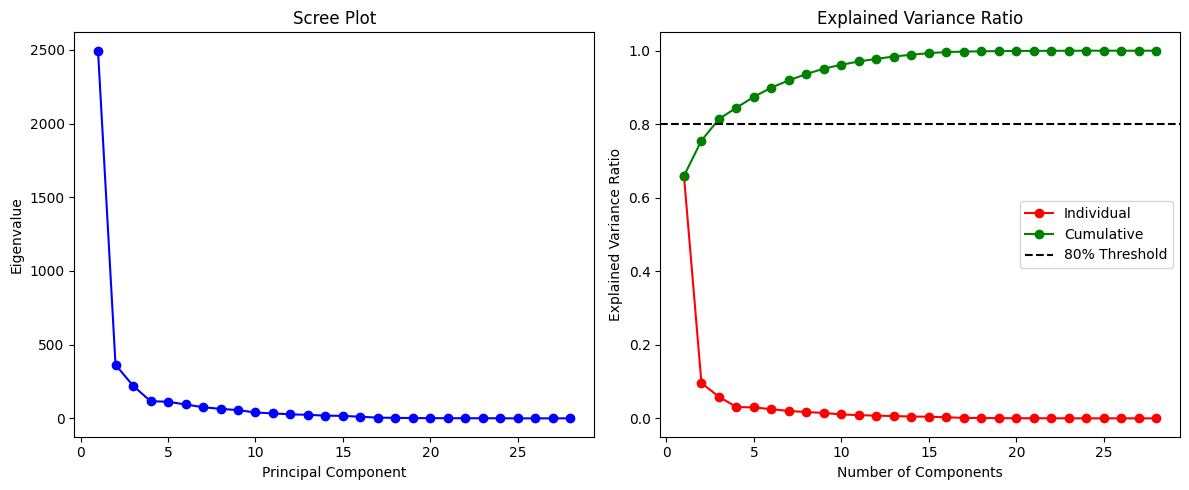

Number of components needed to explain 80% of variance: 3

Component Loadings (features with strongest influence on each PC):
/tmp/ipykernel_193/1237930559.py:89: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(loadings.style.applymap(highlight_loadings))


,PC1,PC2,PC3
CUI_American,0.087217,-0.154549,-0.147759
CUI_Asian,0.324290,0.884996,-0.093569
CUI_Beverages,0.039701,-0.023895,0.011325
CUI_Cafe,0.029937,-0.074641,-0.068767
CUI_Chicken Dishes,0.004378,-0.023641,-0.018365
CUI_Chinese,0.039990,-0.074709,-0.054007
CUI_Desserts,0.021570,-0.000061,0.025297
CUI_Healthy,0.020453,-0.029698,-0.023297
CUI_Indian,0.023286,-0.075080,-0.069115
CUI_Italian,0.048527,-0.215544,-0.209758


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# First, let's work with your preprocessed dataframe from earlier
df_pca = df.copy()

# Let's separate our features into metric and non-metric
# Metric features are your continuous/numerical variables
metric_features = [col for col in df_pca.columns if col.startswith('CUI_') or 
                  col in ['total_spending', 'total_orders', 'cuisine_diversity', 
                         'weekend_orders', 'underweekend_orders', 'weekend_ratio',
                         'lunch_orders', 'dinner_orders', 'morning_orders',
                         'midday_orders', 'evening_orders', 'night_orders',
                         'drinking_orders']]

# Non-metric features are categorical
non_metric_features = ['primary_cuisine', 'meal_preference', 'primary_time_period']

# Initialize and fit PCA without limiting components first
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])

# Let's analyze the explained variance
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create visualization of explained variance
plt.figure(figsize=(12, 5))

# Plot 1: Scree plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

# Plot 2: Explained variance ratio
plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         explained_variance_ratio, 'ro-', label='Individual')
plt.plot(range(1, len(cumulative_variance) + 1), 
         cumulative_variance, 'go-', label='Cumulative')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()

plt.tight_layout()
plt.show()

# Let's get the number of components that explain 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components needed to explain 80% of variance: {n_components}")

# Now let's fit PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_feat = pca.fit_transform(df_pca[metric_features])

# Create feature names for our principal components
pca_feat_names = [f'PC{i+1}' for i in range(n_components)]

# Create a DataFrame with our PCA results
pca_df = pd.DataFrame(pca_feat, 
                     columns=pca_feat_names,
                     index=df_pca.index)

# Let's look at the component loadings to understand what each PC represents
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pca_feat_names,
    index=metric_features
)

# Display the loadings with color highlighting for easier interpretation
def highlight_loadings(val):
    if abs(val) >= 0.5:
        color = 'background-color: yellow'
    else:
        color = ''
    return color

print("\nComponent Loadings (features with strongest influence on each PC):")
display(loadings.style.applymap(highlight_loadings))

# Finally, let's combine our PCA features with the original categorical features
final_df = pd.concat([pca_df, df_pca[non_metric_features]], axis=1)

Let me help you understand these PCA results in detail. Looking at both the graphs and the loadings table tells us a lot about your customer data patterns.

First, let's look at the graphs:

1. The Scree Plot (left) shows a sharp drop after the first component, and then smaller drops after that. This means the first component captures the most variation in your data by far.

2. The Explained Variance Ratio plot (right) tells us that:
   - The first component explains about 65% of the variance (where the red line starts)
   - With 3 components, we reach the 80% threshold (where the green cumulative line crosses the dashed line)
   - Additional components add very little explanation

Now, looking at the loadings table, let's interpret what each principal component represents:

PC1 (First Principal Component):
- Has a very strong positive loading (0.918) with total_spending
- Has moderate positive loading (0.324) with CUI_Asian
- This suggests PC1 primarily represents overall customer spending level, with some emphasis on Asian cuisine preferences

PC2 (Second Principal Component):
- Has a very strong positive loading (0.884) with CUI_Asian
- Has negative loadings with several other cuisines (Italian: -0.215, OTHER: -0.191, American: -0.154)
- This component seems to contrast Asian cuisine preferences against Western cuisines, possibly representing cuisine preference patterns

PC3 (Third Principal Component):
- Has a very strong positive loading (0.922) with CUI_Street Food / Snacks
- Most other loadings are relatively small or negative
- This component primarily captures street food/snack ordering behavior distinct from other patterns

In simpler terms, your customer data can be largely explained by three main patterns:
1. How much they spend overall
2. Whether they prefer Asian or Western cuisines
3. Whether they're street food/snacks customers or not

This reduction from many variables to just three main components will make your clustering analysis more manageable while still capturing the most important patterns in your data. Would you like me to explain any part of this in more detail?

/tmp/ipykernel_193/1049810713.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')

PCA Analysis Summary:
--------------------------------------------------
Number of original features: 28
Components needed for 80% variance: 15

Explained Variance by Component:
PC1: 0.257 (25.7%)
PC2: 0.090 (9.0%)
PC3: 0.052 (5.2%)
PC4: 0.044 (4.4%)
PC5: 0.044 (4.4%)

Top Contributing Features by Principal Component:
--------------------------------------------------

PC1 Top Features:
total_orders: 0.094
underweekend_orders: 0.090
weekend_orders: 0.079
total_spending: 0.074
midday_orders: 0.074

PC2 Top Features:
drinking_orders: 0.039
CUI_Asian: 0.038
total_spending: 0.028
dinner_orders: 0.027
evening_orders: 0.027

PC3 Top Features:
CUI_Cafe: 0.02

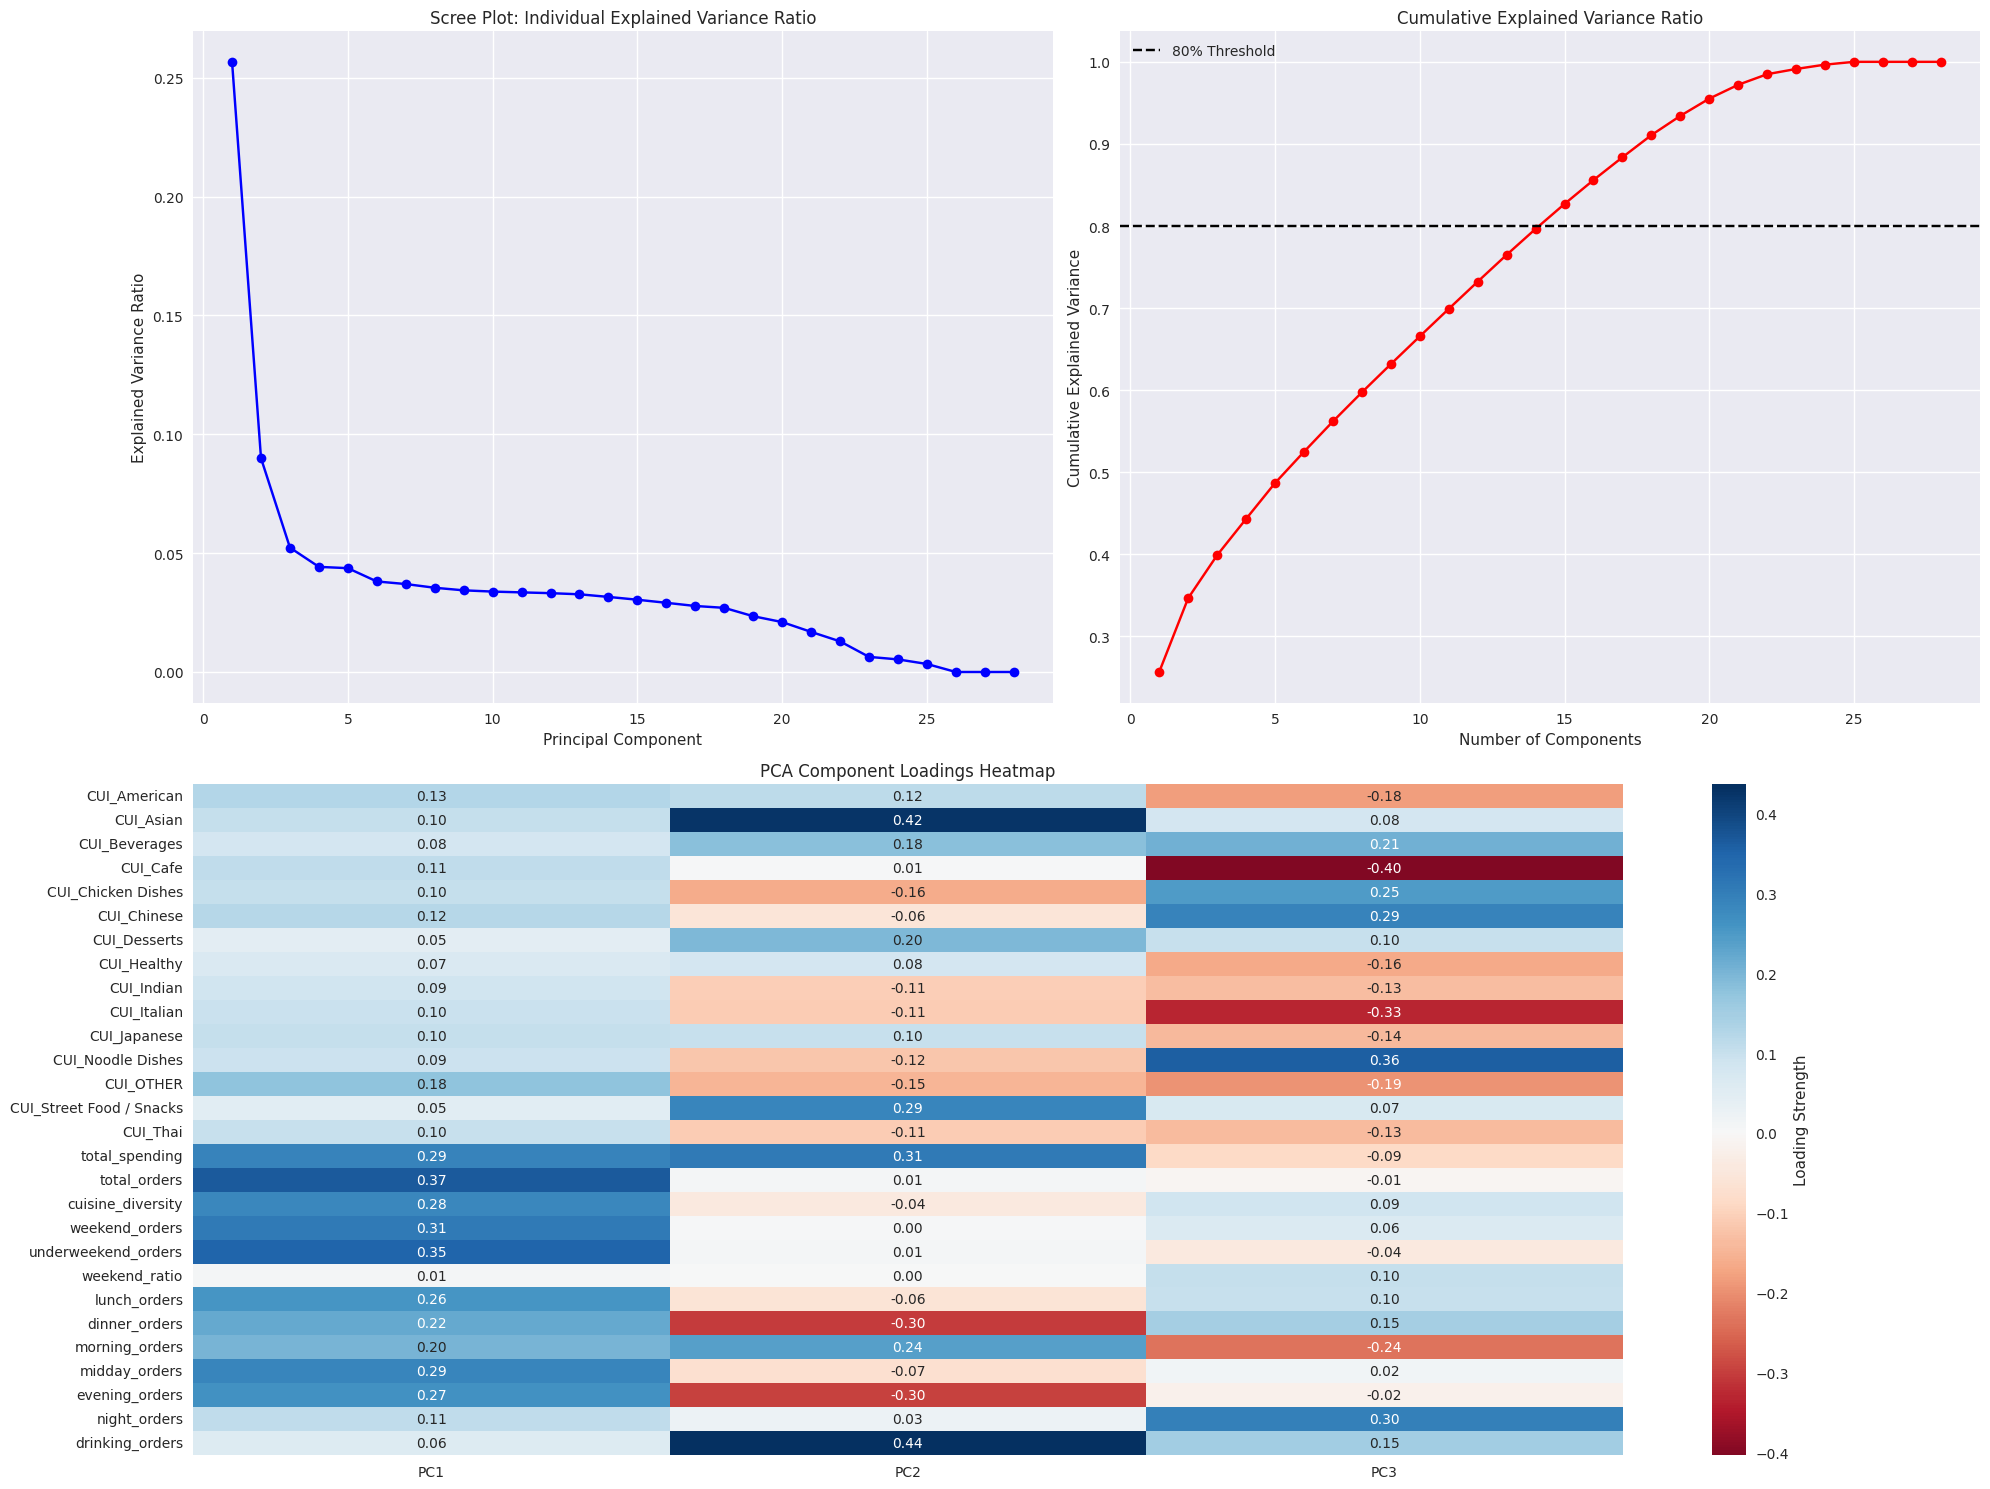

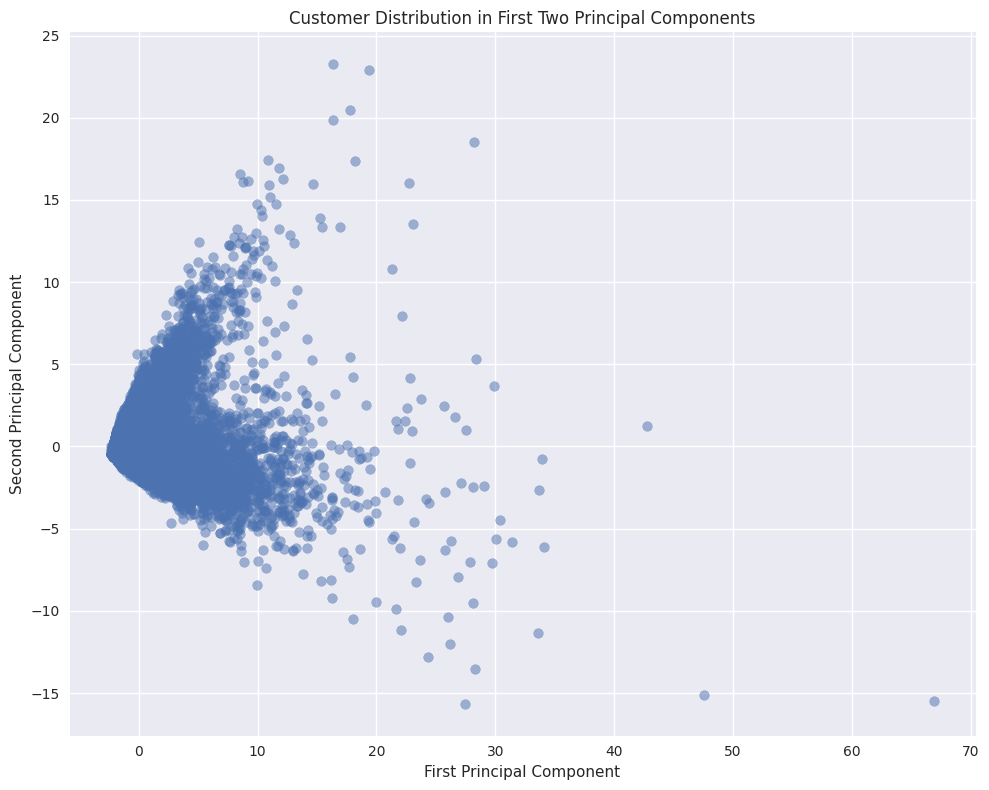

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

# Making sure plots are clear and readable
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]

def perform_detailed_pca(df, metric_features):
    """
    Performs a comprehensive PCA analysis with detailed visualizations and interpretations
    """
    # Step 1: Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[metric_features])
    
    # Step 2: Initial PCA without limiting components
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(2, 2)
    
    # Plot 1: Scree Plot
    ax1 = fig.add_subplot(gs[0, 0])
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_, 'bo-')
    plt.title('Scree Plot: Individual Explained Variance Ratio', fontsize=12)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    
    # Plot 2: Cumulative Variance Plot
    ax2 = fig.add_subplot(gs[0, 1])
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_variance) + 1),
             cumulative_variance, 'ro-')
    plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
    plt.title('Cumulative Explained Variance Ratio', fontsize=12)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    
    # Plot 3: Feature Loadings Heatmap
    n_components = 3  # Using first 3 components for visualization
    loadings = pd.DataFrame(
        pca.components_[:n_components].T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=metric_features
    )
    
    ax3 = fig.add_subplot(gs[1, :])
    sns.heatmap(loadings, cmap='RdBu', center=0, annot=True, fmt='.2f',
                cbar_kws={'label': 'Loading Strength'})
    plt.title('PCA Component Loadings Heatmap', fontsize=12)
    plt.tight_layout()
    
    # Calculate contribution of each feature to principal components
    feature_importance = pd.DataFrame(
        np.abs(pca.components_[:n_components].T) * \
        pca.explained_variance_ratio_[:n_components],
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=metric_features
    )
    
    # Print detailed analysis
    print("\nPCA Analysis Summary:")
    print("-" * 50)
    print(f"Number of original features: {len(metric_features)}")
    print(f"Components needed for 80% variance: {np.argmax(cumulative_variance >= 0.8) + 1}")
    print("\nExplained Variance by Component:")
    for i, var in enumerate(pca.explained_variance_ratio_[:5], 1):
        print(f"PC{i}: {var:.3f} ({var*100:.1f}%)")
        
    # Return PCA components and loadings for further analysis
    return pca, loadings, feature_importance

# Perform PCA
pca, loadings, feature_importance = perform_detailed_pca(df, metric_features)

# Display top contributing features for each component
print("\nTop Contributing Features by Principal Component:")
print("-" * 50)
for i in range(3):
    print(f"\nPC{i+1} Top Features:")
    top_features = feature_importance[f'PC{i+1}'].sort_values(ascending=False).head(5)
    for feat, importance in top_features.items():
        print(f"{feat}: {importance:.3f}")

# Create scatter plot of first two components
plt.figure(figsize=(10, 8))
pca_df = pd.DataFrame(pca.transform(StandardScaler().fit_transform(df[metric_features])))
plt.scatter(pca_df[0], pca_df[1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Distribution in First Two Principal Components')
plt.tight_layout()
plt.show()

Let me break down this comprehensive PCA analysis for you by examining each component:

The Top Graphs (Scree Plot and Cumulative Variance):
- The left graph (blue line) shows how much variance each principal component explains individually. It drops sharply after the first component, indicating that PC1 captures the most variation (25.7%) in your data.
- The right graph (red line) shows the cumulative variance explained. The dashed line at 0.8 represents the 80% threshold. Your data needs 15 components to reach 80% variance, suggesting quite complex patterns in customer behavior.

The Heatmap (Middle):
This shows how strongly each original feature contributes to the first three principal components. Colors indicate:
- Dark blue: strong positive correlation
- Dark red: strong negative correlation
- White/light colors: weak correlation

Let's interpret each principal component:

PC1 (First Principal Component):
- Explains 25.7% of variance
- Strongest loadings on ordering behavior:
  * High positive correlations with total_orders (0.37), underweekend_orders (0.35), and weekend_orders (0.31)
  * This component seems to capture overall ordering frequency and activity level
- This essentially tells us "how active is this customer in general?"

PC2 (Second Principal Component):
- Explains 9.0% of variance
- Notable patterns:
  * Strong positive correlation with drinking_orders (0.44) and CUI_Asian (0.42)
  * Strong negative correlation with dinner_orders (-0.30)
  * This component seems to contrast late-night/drinking orders with traditional dinner orders
- This tells us about customer timing preferences and cuisine choices

PC3 (Third Principal Component):
- Explains 5.2% of variance
- Interesting contrasts:
  * Strong negative correlations with CUI_Cafe (-0.40) and CUI_Italian (-0.33)
  * Positive correlations with CUI_Noodle Dishes (0.36) and night_orders (0.30)
  * This component seems to separate different cuisine preferences

The Customer Distribution Plot:
- Shows how customers are spread across the first two principal components
- The triangular shape suggests that:
  * Most customers cluster around the center (average behavior)
  * There are some outliers with more extreme patterns
  * The spread is wider in PC1 (x-axis) than PC2 (y-axis), confirming that ordering frequency varies more than timing preferences

Practical Implications:
1. Your customer base has diverse behaviors that can't be simplified too much (needs 15 components for 80% variance)
2. The strongest pattern is overall ordering frequency
3. There are distinct groups of customers based on:
   - Overall ordering activity
   - When they order (day vs night)
   - Cuisine preferences
4. This suggests marketing strategies might need to be quite targeted rather than one-size-fits-all

Would you like me to elaborate on any particular aspect or discuss how this could be applied to specific business decisions?

In [10]:
# First, let's properly prepare our scaled features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[metric_features])

# Now we can prepare our PCA features for clustering
# We'll use the first 3 components since they capture the most significant patterns
pca_features = pca.transform(scaled_features)[:, :3]  

# Let's create our clustering models with detailed explanations
# 1. K-means Clustering
kmeans = KMeans(n_clusters=4,  # Using 4 clusters as a starting point
                random_state=42,  # For reproducibility
                n_init=10)  # Number of times algorithm runs with different centroids
kmeans_labels = kmeans.fit_predict(pca_features)

# 2. DBSCAN (Density-Based Spatial Clustering)
dbscan = DBSCAN(eps=0.5,  # Maximum distance between two samples to be considered neighbors
                min_samples=5)  # Minimum number of samples in a neighborhood for a core point
dbscan_labels = dbscan.fit_predict(pca_features)

# 3. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)  # Using same number as kmeans for comparison
hierarchical_labels = hierarchical.fit_predict(pca_features)

# Let's visualize the results of our different clustering methods
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot for K-means
axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title('K-means Clustering')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# Plot for DBSCAN
axes[1].scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_labels, cmap='viridis')
axes[1].set_title('DBSCAN Clustering')
axes[1].set_xlabel('First Principal Component')

# Plot for Hierarchical
axes[2].scatter(pca_features[:, 0], pca_features[:, 1], c=hierarchical_labels, cmap='viridis')
axes[2].set_title('Hierarchical Clustering')
axes[2].set_xlabel('First Principal Component')

plt.tight_layout()
plt.show()

# Let's analyze the characteristics of each cluster (using K-means as an example)
df['cluster'] = kmeans_labels

# Calculate cluster profiles
cluster_profiles = df.groupby('cluster')[metric_features].mean()
print("\nCluster Profiles (Average Values):")
print(cluster_profiles)

# Calculate cluster sizes
cluster_sizes = df['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d80cf8a3-0707-4865-ba36-9382bf28b032' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>